# Table of Content

* [Handling Missing Values and Categorical Data- Notebook 1 in this series](https://www.kaggle.com/mitramir5/missing-values-ordinal-data-and-stories)
* [Definition of Anomalies](#formal-def)
* [Different Types of Anomalies](#types)
* [Detecting Manually](#manual)
* [Data Transformation and it's methods](#transform)
* [Detecting Automatically](#automatic)
* [Comparing methods](#compare)


After handling null values and turning categories into digits and making them ready for our models, Now we want to transform the data for anomaly detection and models that need normaly distributed features. I did my best to thoroghly explain each part, so feel free to skip to the part you need to read. So let's get going 🚶‍♀️ 🚶
<a id="formal-def"></a>
# Why do we need "Anomaly Detection"?

There are several reasons why someone would concider deleting few examples of their dataset, even when the dataset is small and we need every bit of information we can get. Outliers can be destructive to our model and our preception of reality. We want our model to predict the most probable label and not be affected by some random value in our dataset. The best way is to remove as little as possible, but make the models robust so that it can ignore or emulate their effect on our prediction.

<div class="alert alert-warning" role="alert">

<h5><span class="label label-warning", align = "middle">Quick note about this competition</span></h5>
   
The evaluation metric of this competition is RMSE(Root Mean Squared Error). This is a metric that is more sensitive to outliers than other methods such as MAE(Mean Absolute Error). Therefore it is important to construct a model based on non-outliers or make our models robust to them so that we won't get the values similar to them in the predictions for the test set. learn more about these metrics <a href = 'https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d'>here</a>.
</div>
  


In [ ]:
%%HTML
<a id="Analysis"></a>
<center>
<iframe width="700" height="315" src="https://www.youtube.com/embed/cJukBLH4qP4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" style="position: relative;top: 0;left: 0;" allowfullscreen ng-show="showvideo"></iframe>
</center>

## What is the definition and why do we have them?
Outliers are abnormal observations that diverge from other groups. They can have negative effects on our preception of the data and the construction of our model.

**We might have outliers because of:**
Data entry or human errors, damaged or not qualified measurement instruments, data manipulation, dummies made to test detection methods or to add noise, and finally novelties in data.

Even when you generate random numbers from a  distribution(e.g. gaussian), there will be some rare values that stand far away from the mean of all other examples. These are the ones we want to get rid of (or analyze in the real world to know why they are there).

## Should we always remove them?
Well interesting question, No! more precisely, not always! They are there for a reason. Why do we have them? are the measuring tools not working correctly? Are we observing a pattern in the time and place they occur? Maybe there is a bottleneck in our system that is generating them.

  

In [ ]:
import numpy as np
import pandas as pd

# for vis
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
# anomaly and skewness detection 
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from numpy import mean, std

from IPython.display import HTML
from matplotlib import animation
from termcolor import colored

# Importing and concating train and test set
path = '../input/house-prices-advanced-regression-techniques'
train = pd.read_csv(path + r'/train.csv')
test = pd.read_csv(path + r'/test.csv')

train.name = 'train'
test.name = 'test'

# keeping testing id for submission in the future
test_id = test.Id
for df in [train, test]:
    df.drop(columns = ['Id'], inplace = True)
    
df_concat = pd.concat([train, test], axis = 0).reset_index(drop = True)
df_concat.name = 'both dfs'


df_concat.loc[:train.shape[0], 'which'] = 'train'
df_concat.loc[train.shape[0]:, 'which'] = 'test'

Now we quickly handle missing values and ordinal data (for understanding the following code please refer to the [previous kernel](https://www.kaggle.com/mitramir5/missing-values-ordinal-data-and-stories) in this series.)

In [ ]:
# Dropping two unuseful columns
df_concat.drop(columns = ['PoolQC', 'Utilities'], inplace = True)

# Filling missing values

# Filling with zero
# fields about the Garage
for field in ['GarageType', 'GarageFinish','GarageQual', 'GarageCond',
              'BsmtFinType1','BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
              'BsmtFinType2','MiscFeature','Alley','Fence','FireplaceQu',
               'MasVnrType' ] :
    df_concat[field].fillna('None',inplace=True)
    
for field in ['MasVnrArea','BsmtFullBath','BsmtHalfBath'
              ,'BsmtFinSF1','GarageCars','GarageArea','TotalBsmtSF',
             'BsmtUnfSF','BsmtFinSF2','GarageYrBlt','TotalBsmtSF']:
    df_concat[field].fillna(0,inplace=True) 


# Filling with appropriate values
df_concat['LotFrontage'] = df_concat.groupby('Neighborhood')['LotFrontage']\
                          .transform(lambda x: x.fillna(x.mean()))
for feature in ['MSZoning', 'Electrical']:
    df_concat[feature] = df_concat.groupby('Neighborhood')[feature]\
                        .transform(lambda x: x.fillna(x.mode()[0]))

for field in ['SaleType','Exterior1st','Exterior2nd',]:
    df_concat[field].fillna(df_concat[field].mode()[0],inplace=True)
    
df_concat.Functional.fillna('Typ',inplace=True)
df_concat.KitchenQual.fillna('TA',inplace=True)

# Converting categorical data into numerical

### ordinal 
ordinal_fields_with_labelencoder=['LandSlope','YearBuilt','YearRemodAdd',
                                  'CentralAir','GarageYrBlt','PavedDrive',
                                  'YrSold']

### ordinal with labelencoder...
for field in ordinal_fields_with_labelencoder:
    le = LabelEncoder()
    df_concat[field] = le.fit_transform(df_concat[field].values)

features_that_are_already_ordinal = ['OverallQual','OverallCond','MoSold',
                                     'FullBath','KitchenAbvGr','TotRmsAbvGrd']


### ordinal features that need to be sorted with ordinal encoder...
fields_that_need_to_be_ordered = [
              'MSSubClass','ExterQual','LotShape','BsmtQual','BsmtCond',
              'BsmtExposure','BsmtFinType1', 'BsmtFinType2','HeatingQC',
              'Functional','FireplaceQu','KitchenQual', 'GarageFinish',
              'GarageQual','GarageCond','Fence'
                                    ]
for field in  fields_that_need_to_be_ordered:
    df_concat[field] = df_concat[field].astype(str)


orders=[#msclass
    ['20','30','40','45','50','60','70','75','80','85', '90','120','150','160','180','190'],
    #ExterQual
    ['Po','Fa','TA','Gd','Ex'],
    #LotShape
    ['Reg','IR1' ,'IR2','IR3'],
    #BsmtQual
    ['None','Fa','TA','Gd','Ex'],
    #BsmtCond
    ['None','Po','Fa','TA','Gd','Ex'],
    #BsmtExposure
    ['None','No','Mn','Av','Gd'],
    #BsmtFinType1
    ['None','Unf','LwQ', 'Rec','BLQ','ALQ' , 'GLQ' ],
    #BsmtFinType2
   ['None','Unf','LwQ', 'Rec','BLQ','ALQ' , 'GLQ' ],
    #HeatingQC
    ['Po','Fa','TA','Gd','Ex'],
    #Functional
   ['Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],
    #FireplaceQu
    ['None','Po','Fa','TA','Gd','Ex'],
    #KitchenQual
    ['Fa','TA','Gd','Ex'],
    #GarageFinish
    ['None','Unf','RFn','Fin'],
    #GarageQual
    ['None','Po','Fa','TA','Gd','Ex'],
    #GarageCond
    ['None','Po','Fa','TA','Gd','Ex'],
    #PoolQC
    #['None','Fa','Gd','Ex'],
    #Fence
    ['None','MnWw','GdWo','MnPrv','GdPrv'] ]
   

### ordinal features with specific order.....
for i in range(len(orders)):

    ord_en = OrdinalEncoder(categories = {0:orders[i]})
    df_concat.loc[:,fields_that_need_to_be_ordered[i]] = ord_en.fit_transform(df_concat.loc[:,fields_that_need_to_be_ordered[i]].values.reshape(-1,1))

# Finally one hot encoding categorical data that are not ordinal    
df_concat=pd.get_dummies(df_concat.drop(columns = ['which']))
train = df_concat[:train.shape[0]]
test = df_concat[train.shape[0]:].drop(columns = ['SalePrice'])
df_concat.head()

In [ ]:
# One thing we add to the above code from the previous tutorial is 
# finding overfitted features in which more than 99 percent of 
# all the data is filled with one value and removing them.
# This happens after one-hot encoding
# when the appearance of one value is 
# rare between different values of one feature

def finding_over_fitting_features(df, percentage = 99.9):
    overfit=[]
    for feature in df.columns:
        most_frequent=(df[feature] .value_counts().iloc[0])
        if most_frequent/len(df) *100 >percentage:
            overfit.append(feature)
    return(overfit)
overfitted = finding_over_fitting_features(df_concat, percentage = 99.0)
df_concat.drop(columns = overfitted, inplace = True)

<a id="#types"></a>
# What are different types and how to understand them?🎨
## Univariate and Multivariate

1. **Univariate outliers**: When we look at the values in a single feature space (for example only looking at the distribution of the SalePrice column).

2. **Multivariate outliers**: When we look at an n-dimentional space with each dimention representing one feature. In this case because we have too many features to take into account, we cannot simply plot the data and detect which point is away from the normal groups, therefore we use models to do this detection for us.

## Point, Contextual, Collective

For simplicity I'll tell you about my experiment on myself.🧛‍ During the second half of the quarantine, I was loosing that motivation to stay focused and happy so I wanted to see which activities actually contributed to my happines and lightened the mood! Just keep in mind that the main theme here is depression and boredom;

1. **Point/Global Outliers**: While looking at the data, there are points in which I see one significant spike in my happiness. Well when I read my journals I see in that day my sister bought me a nice present. This does not happen very often(unfortunately) this is a random point that can't mean anything in particular 😊
These are single points lying significantly away from the normal groups and distribution. They don't depend on any other feature and are randomly generated.
2. **Contextual/Conditional Outliers**: After a closer look I saw that there were a few day that my mood spiked up and I was very happy. In these days I notice that I've been doing alot of focused studying and also vigoures work outs. So the level of happiness is now related to other tasks of my day. When examples are not outside the usual range of features but are still abnormal compared to the most frequent values we have Contextual outliers. 
3. **Collective outliers**: This is when looking at the data helps us understand some novelties and end up in us making new discoveries! Like when there are some specific days in which I'm observing some high levels of happiness but no specific thing that I can point out to as the cause! Maybe it's publishing videos, maybe it's writing, drawing and all the other activities. Indeed these outliers are the ones that help austro physisists find out about new galaxies or comets!
To put it a bit more formally, they deviate from a non-parametric distribution.


In [ ]:
!git clone https://github.com/mitramir55/mood_swings.git
df = pd.read_csv(r'mood_swings/mood swings.csv', sep = '')

In [ ]:
trace1 = go.Scatter(x=df["day"], y=df["mood"],
                    mode = 'lines', line = dict(width = 2))
frames = [dict(data = [dict(type = 'scatter',
                      x = df["day"][:k],
                      y = df["mood"][:k])
                      ], 
              traces = [0]) for k in range(1, len(df["day"])-1)]


layout = go.Layout(width=1000,
                   height=400,
                   updatemenus=[
                        dict(
                            type='buttons', showactive=False,
                            buttons=[dict(label='Play',
                            method='animate',
                            args=[None,
                                  dict(frame=dict(duration=200),
                                   transition=dict(duration=50),
                                     mode='immediate'              )]
                            )]
                        ),
                    ]              
                  )
layout.update(xaxis=dict(range=[min(df.day),max(df.day)], autorange=False),
              yaxis=dict(range=[0,100],  autorange=False));

go.Figure(data = [trace1], frames = frames,
          layout = layout)

# So now let's see how we can detect them🧐:
So this journey starts with two important questions. 
* Which and how many features are you going to take into account?(Univariate or multivariate)
* whether or not we can assume a distribution for the selected features.



<a id="#manual"></a>
## Manually and With Visual Tools
When we read the discription of this dataset in [here](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt), we'll notice in the SPECIAL NOTES section, the collectors of this dataset mention that we have about 5 outliers in the data. Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). Then they recommend removing houses with more that 4000 square feet from the data. So let's plot it against the Ground Living Area and see what we get. I've highlighted the ones that the discription is talking about.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,8),)
fig.suptitle('Before and After Manually removing outliers')
axes[0].set_title('Before')
axes[1].set_title('After')

g = sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], ax = axes[0])
g.text(4500, 400000, "Outliers", horizontalalignment='left', size='large', color='black', weight='semibold')
g.axvline(4000, ls='--', color = 'red')

idx_manual = np.where(train['GrLivArea']>4000)[0]
train_NoOutlier = train.drop(idx_manual)
g = sns.regplot(x=train_NoOutlier['GrLivArea'], y=train_NoOutlier['SalePrice'], ax = axes[1])


Look at how data is less spread and more concentrated in a smaller range of Ground Living Area. Although you can still look a bit closer and see that there are some very small values in the bottom left corner of the plot that show properties sold with abnormally small values. You can go ahead and remove them and see what happens to your results. I've manually removed Prices lower than 40000 and indeed it helped in the accuracy. We will look at the scientific methods that would do this for us. 

# Let's Use Some Statistics 😎
First let's see how the distribution of The SalePrice is. Now because we're only looking at the sale price this is a univariate outlier detection.

In [ ]:
fig, axes = plt.subplots(figsize=(20,8),)

sns.distplot(train["SalePrice"], kde = True, )

We can also make use of another statistical method called the QQ-plot: 
## QQ-plot?
In a QQ-plot, **we try to compare our data's distribution with a nother distribution(such as a normal bell-curved distribution) and see whether they match**.

In this plot we have two axis; Y axis that shows the quantiles generated from our dataset and X axis that is generated from a normal distribution. Then we simply plot data points based on which quantile they are in, in each our dataset and a normally distributed dataset. If the two distributions match, the datapoints will be in the same quantiles and therefore make up a streight ($X=Y$) line. But if they differ, we'll have points going up and down from this streight line. Learn more [here](https://www.youtube.com/watch?v=okjYjClSjOg).

In [ ]:
fig = plt.figure(figsize = (20,4))
ax = fig.add_subplot(111)
stats.probplot(train.SalePrice, dist=stats.norm, plot = ax)
plt.show()

<a id="transform"></a>
right now we can see that SalePrice data is right skewed. This means that for both regression models and outlier detection we will have some problems if we don't do something about it. Because As you can read in [Jason Brownlee says in his blog](https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/):
> If we know that the distribution of values in the sample is Gaussian or Gaussian-like, we can use the standard deviation of the sample as a cut-off for identifying outliers.

So we have to have a normal distribution to use variance and mean to detect outliers, but why? based [on this question on stackoverflow: ](https://stats.stackexchange.com/questions/129274/outlier-detection-on-skewed-distributions)
> (summarised)When the data is skewed we only tend to expect outliers to be on the skewed part (in our case on the right side). Therefore we forget about the other side unless when they're really extreme!

So without having a symetric bell-shaped distribution, we won't be able to identify outliers correctly. What we have to do is to transform the data. 

## What is Data Transformation and Its Methods?

Transformation is the replacement of a variable by the function of that variable. We can replace our skewed feature, with the root or logarithm of it. See the graph below for more intuition.

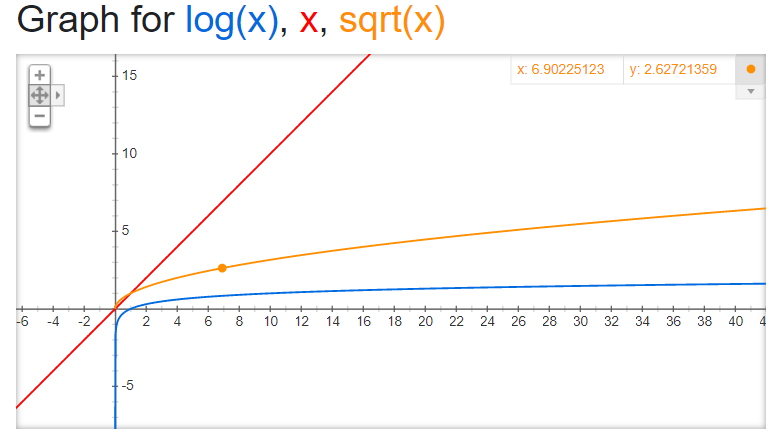

The graph makes it more easy for us to see how log and sqrt are shrinking the big xs to smaller ys so that the right skewed dataset with values spread out to the extremes shrink onto a smaller range.

There are so many other transformations like **cube root**($x^{1/3}$), **reciprocal** ($1/x$) or **negative reciprocal** ($-1/x$), **square** ($x^2$).

The question is which one works best with your data and makes sense. After applying the function we apply a reverse function to bring the values back to their original state.
<div class="alert alert-success" role="alert">
  
Sometimes in the real world we tend not to apply the reverse function as the transformated values are simple and make sense to us:
> If possible, we prefer measurement scales that are  easy to think about. The cube root of a volume and the square root of an area both have the dimensions of length, so far from complicating matters, such transformations may simplify them. 
    <a href = 'http://fmwww.bc.edu/repec/bocode/t/transint.html'>Nicholas J. Cox, Durham University</a>
</div>

Besides all these functions there is one more that often seems a bit confusing but can help us alot in reducing skewness. It's **Box-Cox Transformation**.
## What is Box-Cox Transformation?
When you look at the equasion bellow you'll see we have a **lambda (λ)** that decides for the shape of the transformation. We vary λ from -5 to +5 so to see which one gives us the best approximation of a normal distribution. 
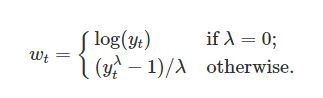

You can imagine how having 1 as λ will have no effect and will simply return $Y-1$ as the new values.

The Box-Cox power transformation searches for various values of lambda by various methods until the best value is found. One of those methods is calculating the log-likelihood of each lambda and see which transformation gives us the biggest likelihood of being a normal distribution.

So for comparing these different functions we use a library to measure the skewness of our data.

In [ ]:
sale = train['SalePrice']
print('Skewness before and after transformation:')
print('Before: ', sale.skew())
sale_t_log = np.log(sale)
print('After log:', sale_t_log.skew())
sale_t_box = boxcox1p(sale,stats.boxcox_normmax(sale+1))
print('After Box-Cox:', sale_t_box.skew())

In [ ]:
fig, axes = plt.subplots(figsize=(20,8),)

g = sns.distplot(sale_t_box)
g.set_title('After transforming the data we get a gussian-like distribution');

***Well Box-Cox crushed it!*** As it turns out we have other features in this dataset that are skewed as well. Just keep in mind that we soon have to transform them as well.

So now let's calculate the variance and mean to see which ones are out of the normal range:

In [ ]:
def anomaly_detection_deletation(normal_dist, alpha):
    list_detected_points=[]
    
    mean_, std_ = mean(normal_dist), std(normal_dist)
    pdf=norm.pdf(normal_dist,mean_, std_)
    anom_indices=np.where(pdf<alpha)[0]
    
    for idx in anom_indices:
        list_detected_points.append((idx))
    
    # plot
    fig, axes = plt.subplots(1, 2, figsize=(20,8),)
    axes[0].set_title('Transformed data with anomalies in red')
    axes[1].set_title('True values with anomalies in red')
    axes[0].set(xlabel='Transformed SalePrice', ylabel='Probability Density of each point')
    axes[1].set(xlabel='True values of SalePrice', ylabel='Probability Density of each point')
    
    g = sns.scatterplot(normal_dist, pdf, ax = axes[0])
    
    
    sns.scatterplot([normal_dist[i] for i in anom_indices],
                    [pdf[i] for i in anom_indices], color = 'red', ax = axes[0])
    
    g.axvline(mean_, ls='--', color = 'red')
    g.text(mean_, 0.5, "mean", size='large', color='black', weight='semibold')
    
    g.axvline(mean_-3*std_, ls='--', color = 'green')    
    g.axvline(mean_+3*std_, ls='--', color = 'green')
    g.text(mean_+3*std_, 0.5, "%99.7", size='large', color='green')
    
    g.axvline(mean_+2*std_, ls='--', color = 'orange')
    g.axvline(mean_-2*std_, ls='--', color = 'orange')
    g.text(mean_+2*std_, 0.5, "%95", size='large', color='orange')
    
    g.axvline(mean_+1*std_, ls='--', color = 'gray')
    g.axvline(mean_-1*std_, ls='--', color = 'gray')
    g.text(mean_+1*std_, 0.5, "%68", size='large', color='gray')
    
    sns.scatterplot(train.SalePrice, pdf, ax = axes[1])
    sns.scatterplot([train.loc[i,'SalePrice'] for i in anom_indices],
                    [pdf[i] for i in anom_indices], color = 'red', ax = axes[1])
    return list_detected_points

idx_stat = anomaly_detection_deletation(sale_t_box,alpha = 0.003)# we choose to have 99.7 percent of our data

What we are doing in the above mentioned function is that we defined a threshold(alpha also known as **p-value**) and we want to take out the points that have a smaller probability of happening than alpha. So when our alpha is 0.003, we color the ones that have smaller than 0.05 probability of happening and in other words, belonging to this distribution.

Ok so now we identified the ones that are not very common and usual and can easily take them out:

In [ ]:
# I comment these to have all the data for the next methods too.
# train.drop(index = [i for (i,x) in anomaly_detection_deletation(sale_t_box ,alpha=0.003)],inplace=True)
# train.reset_index(drop = True,inplace = True)

<a id="#automatic"></a>
# Automatic Detection 🤖
## Minimum Covariance Determination
This is the multivariate version of the method we just used in the previous section. In fact in this method we have to have several Gaussian or Gaussian-like features, and then form an ellipsoid shape with them in space. The features that fall out of this ellipsoid will be our outliers. Take a look at the graph bellow:
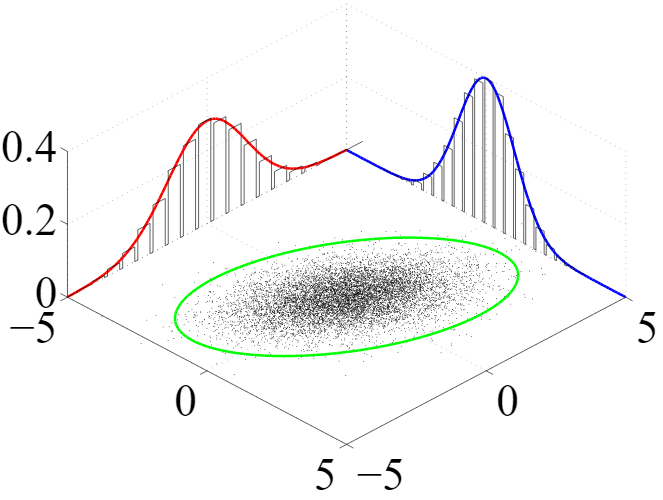
[image source](https://commons.wikimedia.org/wiki/File:Multivariate_normal_sample.svg)

In [ ]:
n = 1000
x = np.random.normal(size = n)
y = np.random.normal(size = n)
z = np.random.normal(size = n)
x_c = np.linspace(-3, 3, n)
y_c = np.sqrt(9-x_c**2)
c_1 = np.concatenate([x_c, -1* x_c])
c_2 = np.concatenate([y_c, -1*y_c])
c_3 = np.array([0]* 2 * n)

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(x, y, z)

ax.plot(c_1, c_2, c_3, color = 'red')
ax.plot(c_2, c_3, c_1, color = 'red')
ax.plot(c_3, c_2, c_1, color = 'red');
for ii in range(0,360,1):
        ax.view_init(elev=10, azim=20)
ax.set_title('Three features each having a Gaussian distribution');


### ---------- for animating the graph add the following code--------###
def animate(frame):
    ax.view_init(10, frame/3)
    return fig


anim = animation.FuncAnimation(fig, animate, frames=200, interval=50)
HTML(anim.to_html5_video())

Depending on how many and which features we want to use, we have to transform the ones that don't have a Gaussian-like disribution. So now we detect the ones that are skewed and apply box-cox transformation on each of them. This is the precedure:
1. Print out the skewness of each feature
2. Transform the ones with skewness>threshold or <-threshold (here threshold = 0.3)
3. Get this transformed dataset and choose a few features who could turn into a Gaussian or Gaussian-like distribution with little skewness.

 We'll also use the transformed data at the end for feeding it to a Ridge regression and comparing different methods. (That's why I separated label and feature)

In [ ]:
def detect_skewness(df):
    skewed=pd.DataFrame(df[:].skew(axis=0).sort_values(ascending=False),columns=['skewness'])
    
    return skewed
detect_skewness(df_concat)

In [ ]:

# transforming the label
label_t = boxcox1p(train.SalePrice,stats.boxcox_normmax(train.SalePrice+1))
# features
df_concat_features_t = df_concat.copy().drop(columns = ['SalePrice']) 
skew_df = detect_skewness(df_concat_features_t)

# skewed more than 0.3?
skewed_features = skew_df[(skew_df.skewness>0.3)|(skew_df.skewness<-0.3)].index

# Transforming with boxcox normmax
for field in list(skewed_features):
    df_concat_features_t[field]=boxcox1p(df_concat_features_t[field],stats.boxcox_normmax(df_concat_features_t[field]+1))
df_concat_features_t.head()

*** If you get a warning** just like I did, it is because of some features that have too many zeros or ones(constant values). *

Now After all the transformation, our data is ready to be fed into our model with different anomaly detection methods. The first item in the outliers list is an empty list indicating the baseline performance.

In [ ]:
skew_df = detect_skewness(df_concat_features_t)

not_skewed = skew_df[(skew_df.skewness<0.1)&(skew_df.skewness>-0.1)].index
train_t = df_concat_features_t.loc[:train.shape[0]-1, not_skewed]
train_t_with_label = pd.concat([train_t, label_t], axis = 1)

In [ ]:
detect_skewness(train_t_with_label)

In [ ]:
from sklearn.covariance import EllipticEnvelope

MCD_model = EllipticEnvelope(contamination = 0.03)
# contamination = the proportion of outliers in the dataset

# model fitting
y_pred = MCD_model.fit_predict(train_t_with_label)

# filter outlier index
idx_MCD = np.where(y_pred == -1)[0] # negative values are outliers

outlier_values = train.iloc[idx_MCD]
# plot data
figure = plt.figure(figsize = (10, 8))
sns.scatterplot(train.GrLivArea, train.SalePrice, color = "blue", s = 6)
# plot outlier values
sns.scatterplot(outlier_values.GrLivArea, outlier_values.SalePrice, color = "red")


## LOF(Local Outlier Factor)🍳
This method is very much like how we group points together in the K-Nearest Neighbors algorithm. we're calculating outliers based on their local neighboorhood density. Just keep in mind these two and their differences:

**k-neighboors:** K points around one example

**k-distance:** The distance between an example and its $K^{th}$ nearest neighbor.
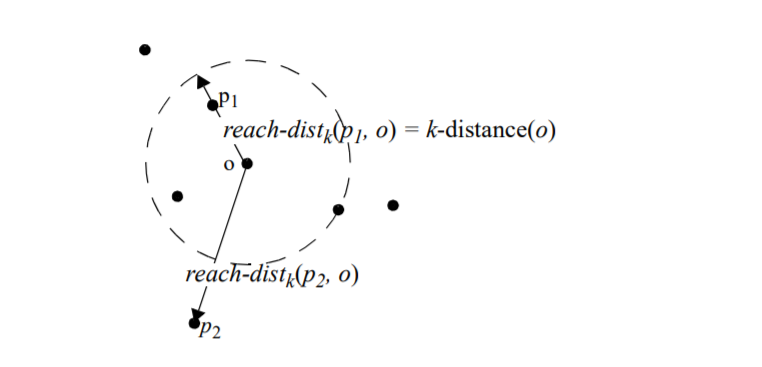
image: [LOF: Identifying Density-Based Local Outliers](https://www.researchgate.net/publication/221214719_LOF_Identifying_Density-Based_Local_Outliers)
1. **Reachability-distance**: We calculate the Reachability-distance for each example.(If points be in a specific radius of the example, we'll put k-distance as the reachability distance, otherwise for points outside that  radius we'll put the distance between that point and our centeral example)
2. **Local Reachability Density (LRD):** Calculate the average of all reachability distances for one example and reverse it (we want the density so the larger the average of distances, the less the dense around one point is)
3. **Local Outlier Factor(LOF)**: We calculate the average LRD of all k-points around an example and compare it with the LRD of our example. (We divide them therefore the closer it is to 1, the more likely it is  to be similar to its neighbors and not an outlier.)

For equations and mathematical concepts [read this blog](https://towardsdatascience.com/local-outlier-factor-lof-algorithm-for-outlier-identification-8efb887d9843).
Because we'll use different features to detect outlier, this will be a multivariate prediction.
Bellow we're calculating the density based on the euclidean distances between examples.

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

lof_model = LocalOutlierFactor(n_neighbors = 150, metric = "manhattan",
                            contamination = 0.01)
# which features to take into account?
selected_features = 'all'
# model fitting
if selected_features == 'all': y_pred = lof_model.fit_predict(train[:])
else: y_pred = lof_model.fit_predict(train[features])
# filter outlier index
idx_LOF = np.where(y_pred == -1)[0] # negative values are outliers

outlier_values = train.iloc[idx_LOF]
# plot data
figure = plt.figure(figsize = (10, 8))
sns.scatterplot(train.GrLivArea, train.SalePrice, color = "blue", s = 6)
# plot outlier values
sns.scatterplot(outlier_values.GrLivArea, outlier_values.SalePrice, color = "red")

Interesting! We took all the features into account and some points that don't even seem like outliers while plotted on this graph, are distinguished as anomalies. This time the smaller the score, the more likely it is that we're detecting an outlier!

## Isolation Forests🌳
In this method we try to isolate the anomalies based on their divergent features(multivariate) and their rare appearance.
>  iForest also works well in high dimensional problems which have a large number of irrelevant attributes,
and in situations where training set does not contain any
anomalies. [Iforests Paper](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf?q=isolation-forest)

**What happens in iforests?**
1. We recursively partition data based on random features and make decision trees.
2. Then we calculate a **path length** which is the average path length to get to the node of all the trees in our forest for each examples.
3. We compare these lengths. The examples with the smallest length(score) are the anomalies. As they are very different in features and are less than other groups and required less partitioning in a high dimentional space to get to the node.

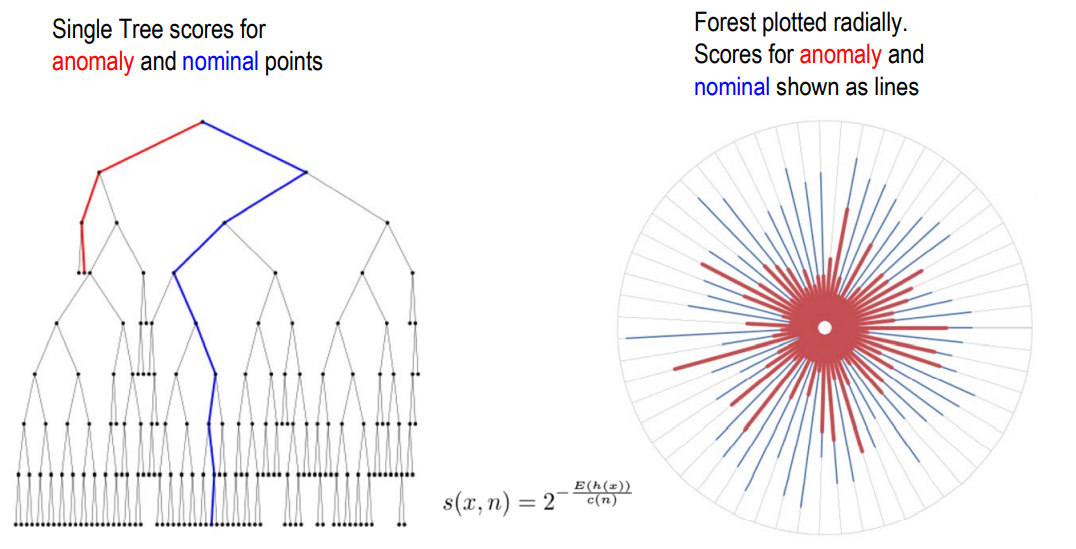
image: [Sahand Harir-LSST Workshop 2018](file:///D:/Machine%20Learning/Coursera_Deep/hariri_forest.pdf)

In [ ]:
from sklearn.ensemble import IsolationForest

isof = IsolationForest(contamination='auto')
# which features to take into account?
selected_features = 'all'
# model fitting
if selected_features == 'all': y_pred = isof.fit_predict(train[:])
else: y_pred = isof.fit_predict(train[features])

# filter outlier index
idx_isof = np.where(y_pred == -1)[0]
outlier_values = train.iloc[idx_isof]

# plot data
figure = plt.figure(figsize = (10, 8))
sns.scatterplot(train.GrLivArea, train.SalePrice, color = "blue", s = 6)
# plot outlier values
sns.scatterplot(outlier_values.GrLivArea, outlier_values.SalePrice, color = "red")

<a id="#compare"></a>
# Comparing Methods🧘🏻‍
Now we want to know which method is actually giving us the best results, so we're going to use some simple algorithms to determine which would work the best for us. Although keep in mind that for algorithms like linear regression, lasso, Ridge,etc. we need to have unskewed data, so we first check which ones are skewed and then transform them with the same methods as we did earlier.

In [ ]:
#Calculates the mean of cv and r2 scores
n_splits=5
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


def tell_me(model,x,y):
    kf=KFold(n_splits,shuffle=True)
    cv_mse_errors=np.sqrt(-cross_val_score(model, x,y, 
                                           scoring="neg_mean_squared_error",cv = kf))
    cv_r2_scores=cross_val_score(model, x,y, scoring="r2", cv =5 ) 

    print('Mean of all the MSE errors: ',np.mean(cv_mse_errors))
    
    print('Mean of all the r^2 scores ',np.mean(cv_r2_scores))
    

In [ ]:
outliers = [[], idx_manual,idx_stat, idx_LOF, idx_isof, idx_MCD]
for i, idx in enumerate(outliers):
    print(colored('method ', 'green'), i+1)
    print('number of deleted points: ', colored(len(idx), 'red'))
    
    tell_me(Ridge(),df_concat_features_t[:train.shape[0]].drop(index = idx), label_t.drop(index = idx))

Some great resources! make sure to check them out for more info:
* [Sergio Santoyo on TowardsDataScience](https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561)
* [Data Skewness and Transformation by Nicholas J. Cox, Durham University](http://fmwww.bc.edu/repec/bocode/t/transint.html)
* [Box-Cox Transformation-1](https://www.statisticshowto.com/box-cox-transformation/)
* [Box-Cox Transformation-2](https://towardsdatascience.com/box-cox-transformation-explained-51d745e34203)
* [P-value intuition by Cassie Kozyrkov](https://youtu.be/9jW9G8MO4PQ)
* [Isolation Forests](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf?q=isolation-forest)
* [Local Outlier Factor on TowardsDataScience](https://towardsdatascience.com/local-outlier-factor-lof-algorithm-for-outlier-identification-8efb887d9843)
* [Local Outlier Factor on GeeksForGeeks](https://www.geeksforgeeks.org/local-outlier-factor/)

Thanks for reading this notebook! I hope it was useful :)
# Also please Upvode if it was ;)